In [1]:
import itertools
import pandas as pd
import os
import seaborn as sns

In [2]:
sns.set_style('whitegrid')
sns.set_context('paper')
pal = sns.color_palette("cubehelix", 3)[::]
nice_fonts = {
        # Use LaTeX to write all text
        "text.usetex": True,
        "font.family": "serif",
        "axes.labelsize": 12,
        "font.size": 12,
        # Make the legend/label fonts a little smaller
        "legend.fontsize": 10,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
}

In [3]:
_SET_ALL = "ALL"
_SET_UCCSD = "UCCSD"

_METRIC_2QGATES = "2qGates"
_METRIC_2QDEPTH = "2qDepth"

# Specify which graph to produce
test_set = _SET_ALL
metric = _METRIC_2QDEPTH

In [4]:
ibm_pf_config = 'tket_paper_config.csv'
uccsd_config = 'chem_config.csv'
if test_set == _SET_ALL:
    config_df = pd.read_csv(ibm_pf_config, index_col='Filename')
    uccsd_config_df = pd.read_csv(uccsd_config, index_col='Filename')
    config_df = pd.concat([config_df, uccsd_config_df])
elif test_set == _SET_UCCSD:
    config_df = pd.read_csv(uccsd_config, index_col='Filename')

In [5]:
bench_qis = 'results/qiskit-terra_0.12.0/'
bench_quil = 'results/quilc_1.16.3/'
bench_tket = 'results/tket_0.4.1/'
bench_ucc_qis = 'chem_results/qiskit-terra_0.12.0/'
bench_ucc_quil = 'chem_results/quilc_1.16.3/'
bench_ucc_tket = 'chem_results/tket_0.4.1/'

bench_qis_files = [(('Qiskit', x[18:-4]), pd.read_csv(bench_qis+x)) for x in os.listdir(bench_qis)]
bench_quil_files = [(('Quilc', x[15:-4]), pd.read_csv(bench_quil+x)) for x in os.listdir(bench_quil)]
bench_tket_files = [(('FullPass', x[18:-4]), pd.read_csv(bench_tket+x)) for x in os.listdir(bench_tket)]
bench_qis_ucc_files = [(('Qiskit', x[22:-4]), pd.read_csv(bench_ucc_qis+x)) for x in os.listdir(bench_ucc_qis)]
bench_quil_ucc_files = [(('Quilc', x[19:-4]), pd.read_csv(bench_ucc_quil+x)) for x in os.listdir(bench_ucc_quil)]
bench_tket_full_ucc_files = [(('FullPass', x[22:-4]), pd.read_csv(bench_ucc_tket+x)) for x in os.listdir(bench_ucc_tket) if 'Full' in x]
bench_tket_chem_ucc_files = [(('ChemPass', x[22:-4]), pd.read_csv(bench_ucc_tket+x)) for x in os.listdir(bench_ucc_tket) if 'Chem' in x]

if test_set == _SET_ALL:
    all_files = itertools.chain(bench_qis_files, bench_quil_files, bench_tket_files, bench_qis_ucc_files, bench_quil_ucc_files, bench_tket_full_ucc_files)
elif test_set == _SET_UCCSD:
    all_files = itertools.chain(bench_qis_ucc_files, bench_quil_ucc_files, bench_tket_full_ucc_files, bench_tket_chem_ucc_files)

keys, dfs = zip(*all_files)
allbench = pd.concat(dfs, keys=keys)
allbench = allbench.reset_index().set_index('Filename')
allbench = config_df.merge(allbench, on='Filename', how='inner')
allbench.rename(inplace=True, columns={
    'level_0': 'Compiler',
    'level_1': 'Architecture',
    'Gate count_x': 'Gates in',
    'Depth_x': 'Depth in',
    '2qb gate count_x': 'Two-qubit gates in',
    '2qb depth_x': 'Two-qubit depth in',
    'Gate count_y': 'Gates out',
    'Depth_y': 'Depth out',
    '2qb gate count_y': 'Two-qubit gates out',
    '2qb depth_y': 'Two-qubit depth out',
})
allbench = allbench.drop(columns=["level_2"])

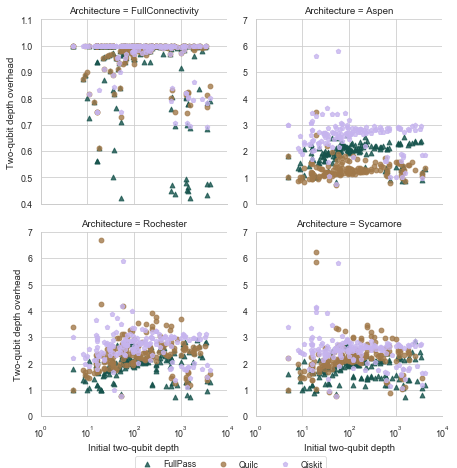

In [6]:
# cpal = sns.color_palette('Set2')
if test_set == _SET_ALL:
    compiler_look = [
        ('FullPass', 'FullPass', pal[0], '^'),
        ('Quilc', 'Quilc', pal[1], 'o'),
        ('Qiskit', 'Qiskit', pal[2], 'p'),
    ]
    y_cap = 7
elif test_set == _SET_UCCSD:
    compiler_look = [
        ('FullPass', 'FullPass', pal[0], '^'),
        ('ChemPass', 'ChemPass', pal[0], 'x'),
        ('Quilc', 'Quilc', pal[1], 'o'),
        ('Qiskit', 'Qiskit', pal[2], 'p'),
    ]
    y_cap = 4

comp_order, comp_labels, comp_cols, comp_marker = zip(*compiler_look)
arcs = ['FullConnectivity', 'Aspen', 'Rochester', 'Sycamore']
filtb = allbench[allbench.notnull().all(axis=1)]

filtb['G2dif'] = filtb['Two-qubit gates out']/filtb['Two-qubit gates in']
filtb['D2dif'] = filtb['Two-qubit depth out']/filtb['Two-qubit depth in']


if metric == _METRIC_2QGATES:
    x_field = 'Two-qubit gates in'
    column_to_show = 'G2dif'
elif metric == _METRIC_2QDEPTH:
    x_field = 'Two-qubit depth in'
    column_to_show = 'D2dif'
filtb = filtb.loc[(filtb['G2dif'] != 0)]
g2 = sns.lmplot(data=filtb, 
                x=x_field, 
                y=column_to_show,
                fit_reg=False,
                col='Architecture',
                col_order=(arcs),
                col_wrap=2,
                hue='Compiler',
                hue_order=comp_order,
                palette=comp_cols,
                markers=list(comp_marker),
                sharey=False,
                sharex=True,
                height=3.2,
                legend=False
             )

if metric == _METRIC_2QGATES:
    g2.set_axis_labels("Initial two-qubit gate count", "Two-qubit gate overhead")
elif metric == _METRIC_2QDEPTH:
    g2.set_axis_labels("Initial two-qubit depth", "Two-qubit depth overhead")


for i in range(len(arcs)):
    g2.axes[i].set_ylim(0, y_cap)
    # pass

g2.axes[0].set_xscale('log')
g2.axes[0].set_xlim(1e0, 1e4)

handles = g2._legend_data.values()
g2.fig.legend(handles=handles, labels=comp_labels,bbox_to_anchor=(0.5, -0.018), loc='lower center', ncol=len(compiler_look))
g2.axes[0].set_ylim(0.4, 1.1)

set_str = {
    _SET_ALL : "all",
    _SET_UCCSD : "uccsd"
}
metric_str = {
    _METRIC_2QGATES : "g2dif",
    _METRIC_2QDEPTH : "d2dif"
}
g2.savefig('{met}_{set}.pdf'.format(met=metric_str[metric], set=set_str[test_set]))

In [7]:
allmeans = allbench[allbench.notnull().all(axis=1)]
allmeans['G2dif'] = allmeans['Two-qubit gates out']/allmeans['Two-qubit gates in']
allmeans['D2dif'] = allmeans['Two-qubit depth out']/allmeans['Two-qubit depth in']
arcs = ['FullConnectivity', 'Aspen', 'Rochester', 'Sycamore']

if test_set == _SET_ALL:
    coms = ['FullPass', 'Quilc', 'Qiskit']
elif test_set == _SET_UCCSD:
    coms = ['FullPass', 'ChemPass', 'Quilc', 'Qiskit']

if metric == _METRIC_2QGATES:
    column_to_avg = 'G2dif'
elif metric == _METRIC_2QDEPTH:
    column_to_avg = 'D2dif'

meandict = {'Compiler':coms}
meandict.update({k: [] for k in arcs})
for com in coms:
    for ar in arcs:
        series = allmeans.loc[((allmeans['Compiler'] == com) & (allmeans['Architecture'] == ar))][column_to_avg]
        meandict[ar].append('${:.3f}\pm{:.3f}$'.format(series.mean(), series.sem()))
mean_df = pd.DataFrame(meandict)
mean_df

,Compiler,FullConnectivity,Aspen,Rochester,Sycamore
0,FullPass,$0.898\pm0.014$,$1.844\pm0.040$,$1.924\pm0.041$,$1.780\pm0.038$
1,Quilc,$0.950\pm0.010$,$1.312\pm0.027$,$2.418\pm0.063$,$2.223\pm0.053$
2,Qiskit,$0.955\pm0.010$,$2.631\pm0.065$,$2.748\pm0.081$,$2.473\pm0.045$
